In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, make_scorer, roc_curve

In [72]:
# записываем данные в датафреймы
df_contract = pd.read_csv(r'C:\Users\silki\Desktop\ucheba\contract.csv') 
df_internet = pd.read_csv(r'C:\Users\silki\Desktop\ucheba\internet.csv')
df_personal = pd.read_csv(r'C:\Users\silki\Desktop\ucheba\personal.csv') 
df_phone = pd.read_csv(r'C:\Users\silki\Desktop\ucheba\phone.csv')

In [73]:
def data_preview(data):
    display(data.sample(5))
    print("-" * 100)
    data.info()
    print("-" * 100)
    print("Пропуски в данных")
    display(data.isna().mean().sort_values(ascending=False))
    print("-" * 100)
    print(f"Количество явных дубликатов - {data.duplicated().sum()}")
    print("-" * 100)
    display(data.describe())
    print("-" * 100)
    print("-" * 100)

# Информация о договорах

In [74]:
data_preview(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3984,5884-FBCTL,2014-02-01,No,Two year,No,Bank transfer (automatic),25.10,1857.85
1071,3097-NNSPB,2019-08-01,2019-10-01 00:00:00,Month-to-month,Yes,Credit card (automatic),49.05,91.1
6319,8904-OPDCK,2015-08-01,No,Month-to-month,Yes,Bank transfer (automatic),24.95,1364.75
2712,5133-VRSAB,2019-06-01,No,Month-to-month,No,Mailed check,29.35,216.45
3382,6285-FTQBF,2014-02-01,No,Two year,No,Credit card (automatic),25.55,1867.7


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [75]:
# смотрим значения полей
df_contract['BeginDate'].value_counts()

2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

In [76]:
df_contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [77]:
df_contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [78]:
df_contract['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

In [79]:
df_contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [80]:
df_contract['MonthlyCharges'].value_counts()

20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
23.65      1
114.70     1
43.65      1
87.80      1
78.70      1
Name: MonthlyCharges, Length: 1585, dtype: int64

In [81]:
df_contract['TotalCharges'].value_counts()
# имеются неявные пропуски

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

# Информация о интернет услугах

In [82]:
data_preview(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
283,4654-DLAMQ,Fiber optic,Yes,Yes,Yes,No,No,Yes
2737,7730-IUTDZ,Fiber optic,Yes,No,No,No,No,No
2024,4910-GMJOT,Fiber optic,No,No,No,No,Yes,Yes
582,2684-EIWEO,Fiber optic,Yes,Yes,Yes,No,No,No
5297,4919-MOAVT,Fiber optic,No,No,No,No,No,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [83]:
df_internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [84]:
df_internet['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

In [85]:
df_internet['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

In [86]:
df_internet['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

In [87]:
df_internet['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

In [88]:
df_internet['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

In [89]:
df_internet['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

# Информация о данных клиентов

In [90]:
data_preview(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
1682,9225-BZLNZ,Male,0,Yes,No
6487,5998-DZLYR,Female,0,Yes,No
1115,1271-UODNO,Male,0,No,No
315,5027-YOCXN,Male,0,Yes,Yes
6855,8738-JOKAR,Female,0,No,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [91]:
df_personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [92]:
df_personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [93]:
df_personal['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [94]:
df_personal['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

# Информация о телефонной связи

In [95]:
data_preview(df_phone)

,customerID,MultipleLines
4100,3956-MGXOG,No
2497,7693-QPEFS,Yes
541,0374-FIUCA,No
1847,8272-ONJLV,No
549,8672-OAUPW,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
----------------------------------------------------------------------------------------------------
Пропуски в данных


customerID       0.0
MultipleLines    0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [96]:
df_phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

Явные пропуски и дубликаты не найдены

BeginDate - нужно привести к datetime
EndDate - нужно привести к datetime, "No" нужно заменить на уникальную дату, в нашем случае на дату актуальности датасета 2020-02-1
TotalCharges - нужно избавится от неявных пропусков, заполняем нулями

# Исследовательский анализ данных

## Приведение форматов данных

In [97]:
# заменим "No" на дату актуальности датасета 2020-02-1
df_contract['EndDate'] = df_contract['EndDate'].replace(['No'], ['2020-02-01'])

In [98]:
# заменим неявные пропуски нулями
df_contract['TotalCharges'] = df_contract['TotalCharges'].replace([' '], 0)

In [99]:
# приводим поля BeginDate и EndDate к типу datetime
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'],format = '%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'],format = '%Y-%m-%d')
# поля MonthlyCharges и TotalCharges приводим к целочисленному типу
df_contract['MonthlyCharges'] = df_contract['MonthlyCharges'].astype('float')
df_contract['MonthlyCharges'] = df_contract['MonthlyCharges'].astype('int')
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('int')

# Объединяем данные в одну таблицу

In [100]:
# объединяем по customeriID 
df_telecom = df_contract.set_index('customerID').join(df_phone.set_index('customerID'))
df_telecom = df_telecom.join(df_personal.set_index('customerID'))
df_telecom = df_telecom.join(df_internet.set_index('customerID'))

In [101]:
data_preview(df_telecom)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
9589-ABEPT,2014-05-01,2020-02-01,Two year,Yes,Mailed check,92,6460,Yes,Male,0,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,No
8146-QQKZH,2014-03-01,2020-02-01,Two year,No,Bank transfer (automatic),81,5924,No,Female,0,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes
3537-HPKQT,2015-07-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),77,4266,Yes,Female,0,Yes,No,Fiber optic,No,Yes,No,No,No,No
6258-NGCNG,2019-07-01,2020-02-01,Month-to-month,No,Mailed check,23,173,Yes,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4325-NFSKC,2018-03-01,2019-10-01,Month-to-month,Yes,Electronic check,90,1660,Yes,Male,1,No,No,Fiber optic,Yes,No,No,No,Yes,No


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   int32         
 6   TotalCharges      7043 non-null   int32         
 7   MultipleLines     6361 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   551

StreamingMovies     0.216669
StreamingTV         0.216669
TechSupport         0.216669
DeviceProtection    0.216669
OnlineBackup        0.216669
OnlineSecurity      0.216669
InternetService     0.216669
MultipleLines       0.096834
Partner             0.000000
Dependents          0.000000
BeginDate           0.000000
EndDate             0.000000
gender              0.000000
TotalCharges        0.000000
MonthlyCharges      0.000000
PaymentMethod       0.000000
PaperlessBilling    0.000000
Type                0.000000
SeniorCitizen       0.000000
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 103
----------------------------------------------------------------------------------------------------


,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,64.295897,2279.265086,0.162147
std,30.092727,2266.790864,0.368612
min,18.000000,0.000000,0.000000
25%,35.000000,398.000000,0.000000
50%,70.000000,1394.000000,0.000000
75%,89.000000,3786.500000,0.000000
max,118.000000,8684.000000,1.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [102]:
# появились пропуски заполним их "No", заменим No и Yes на 0 и 1 соотвественно, потому что со строковыми признаками работать неудобно
def coding_for_binary_features(df, column):
    df[column].fillna(0, inplace = True) # пропуск соответствует значению "No"
    df[column] = df[column].replace(['No'], 0)
    df[column] = df[column].replace(['Yes'], 1)
    return df[column]

In [103]:
df_telecom['MultipleLines'] = coding_for_binary_features(df_telecom, 'MultipleLines')
df_telecom['InternetService'] = coding_for_binary_features(df_telecom, 'InternetService')
df_telecom['OnlineSecurity'] = coding_for_binary_features(df_telecom, 'OnlineSecurity')
df_telecom['OnlineBackup'] = coding_for_binary_features(df_telecom, 'OnlineBackup')
df_telecom['DeviceProtection'] = coding_for_binary_features(df_telecom, 'DeviceProtection')
df_telecom['TechSupport'] = coding_for_binary_features(df_telecom, 'TechSupport')
df_telecom['StreamingTV'] = coding_for_binary_features(df_telecom, 'StreamingTV')
df_telecom['StreamingMovies'] = coding_for_binary_features(df_telecom, 'StreamingMovies')
df_telecom['PaperlessBilling'] = coding_for_binary_features(df_telecom, 'PaperlessBilling')
df_telecom['Partner'] = coding_for_binary_features(df_telecom, 'Partner')
df_telecom['Dependents'] = coding_for_binary_features(df_telecom, 'Dependents')

df_telecom['is_male'] = df_telecom['gender'].replace(['Male'], 1).replace(['Female'], 0)
df_telecom['is_DSL_service'] = df_telecom['InternetService'].replace(['DSL'], 1).replace(['Fiber optic'], 0)

In [104]:
# удаляем теперь неактуальные столбцы
df_telecom = df_telecom.drop(['gender', 'InternetService'], axis=1)

In [105]:
data_preview(df_telecom)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,is_male,is_DSL_service
customerID,,,,,,,,,,,,,,,,,,,
3018-TFTSU,2018-10-01,2019-10-01,Month-to-month,0,Bank transfer (automatic),81,858,0,0,0,0,1,0,1,0,0,0,1,0
6339-DKLMK,2019-01-01,2020-02-01,Month-to-month,1,Electronic check,31,389,0,0,0,0,0,1,0,0,0,0,0,1
0980-PVMRC,2016-10-01,2020-02-01,Month-to-month,1,Electronic check,50,2036,0,0,1,1,0,1,0,0,1,1,0,1
4254-QPEDE,2015-10-01,2020-02-01,Two year,0,Credit card (automatic),66,3330,0,0,1,0,1,1,1,1,1,1,0,1
1228-FZFRV,2015-08-01,2019-10-01,Month-to-month,0,Credit card (automatic),105,5341,1,0,1,1,1,0,1,0,1,1,1,0


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   int64         
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   int32         
 6   TotalCharges      7043 non-null   int32         
 7   MultipleLines     7043 non-null   int64         
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   int64         
 10  Dependents        7043 non-null   int64         
 11  OnlineSecurity    7043 non-null   int64         
 12  OnlineBackup      704

BeginDate           0.0
Dependents          0.0
is_male             0.0
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
DeviceProtection    0.0
OnlineBackup        0.0
OnlineSecurity      0.0
Partner             0.0
EndDate             0.0
SeniorCitizen       0.0
MultipleLines       0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Type                0.0
is_DSL_service      0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 103
----------------------------------------------------------------------------------------------------


,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,is_male,is_DSL_service
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.592219,64.295897,2279.265086,0.421837,0.162147,0.483033,0.299588,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.504756,0.343746
std,0.491457,30.092727,2266.790864,0.493888,0.368612,0.499748,0.458110,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.500013,0.474991
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.000000,398.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,70.000000,1394.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,89.000000,3786.500000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,118.000000,8684.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


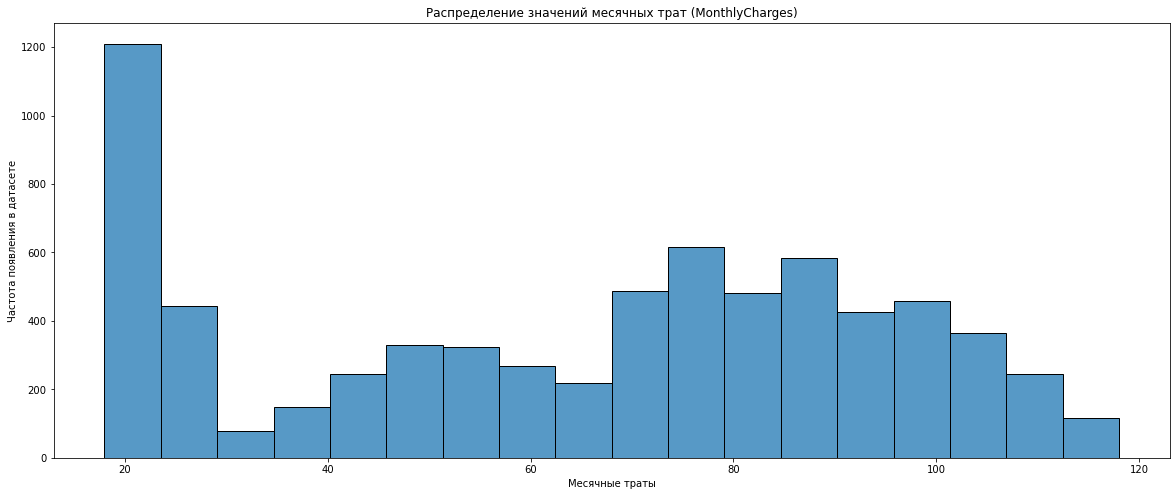

In [106]:
plt.figure(figsize = (20,8))
sns.histplot(df_telecom['MonthlyCharges'])
plt.title('Распределение значений месячных трат (MonthlyCharges)')
plt.xlabel('Месячные траты')
plt.ylabel('Частота появления в датасете');
plt.show()

Проведем группировку

In [107]:
df_telecom['MonthlyChargesGroup'] = pd.qcut(df_telecom['MonthlyCharges'], 3, labels=[0, 1, 2])

In [108]:
df_telecom['MonthlyChargesGroup'].value_counts(normalize=True)

0    0.342326
2    0.333097
1    0.324578
Name: MonthlyChargesGroup, dtype: float64

Выделяем клиентов по целевому признаку

In [109]:
df_telecom['escape_client'] = (df_telecom['EndDate'] != "2020-02-01") * 1

In [110]:
df_telecom['escape_client'].value_counts(normalize=True)


0    0.73463
1    0.26537
Name: escape_client, dtype: float64

In [111]:
df_group_0 = df_telecom.query('MonthlyChargesGroup == 0')
df_group_1 = df_telecom.query('MonthlyChargesGroup == 1')
df_group_2 = df_telecom.query('MonthlyChargesGroup == 2')

In [112]:
stats_pivot_on_groups = pd.DataFrame()
stats_pivot_on_groups['group_0'] = df_group_0.describe().T['mean']
stats_pivot_on_groups['group_1'] = df_group_1.describe().T['mean']
stats_pivot_on_groups['group_2'] = df_group_2.describe().T['mean']

In [113]:
stats_pivot_on_groups

,group_0,group_1,group_2
PaperlessBilling,0.388221,0.628609,0.766411
MonthlyCharges,28.085856,69.052056,96.874680
TotalCharges,721.800912,1979.614173,4171.868713
MultipleLines,0.156781,0.371391,0.743393
SeniorCitizen,0.070095,0.163605,0.255328
Partner,0.431771,0.451444,0.566496
Dependents,0.359187,0.281277,0.256181
OnlineSecurity,0.098714,0.388889,0.380222
OnlineBackup,0.090419,0.391076,0.561381
DeviceProtection,0.081294,0.362205,0.595908


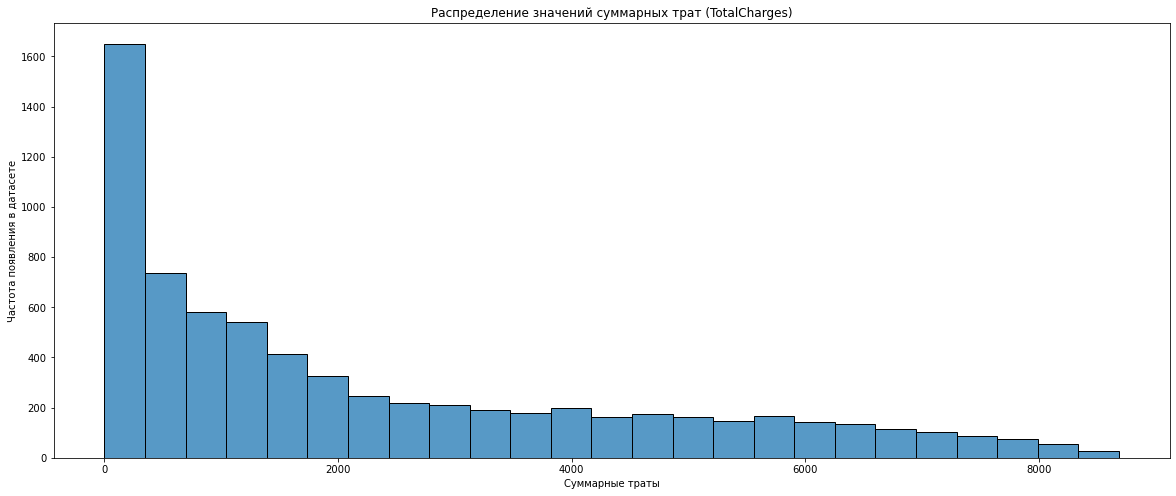

In [114]:
plt.figure(figsize = (20,8))
sns.histplot(df_telecom['TotalCharges'])
plt.title('Распределение значений суммарных трат (TotalCharges)')
plt.xlabel('Суммарные траты')
plt.ylabel('Частота появления в датасете');

In [115]:
df_telecom.query('TotalCharges == 0')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,SeniorCitizen,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,is_male,is_DSL_service,MonthlyChargesGroup,escape_client
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52,0,0,0,1,...,1,0,1,1,1,0,0,1,1,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80,0,0,0,1,...,1,1,1,0,1,1,0,1,1,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56,0,0,0,1,...,1,1,1,1,1,0,0,1,1,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


Это клиенты, начавшие пользоваться услугами в феврале 2020 года, в этом случае суммарные траты равны месячным

In [116]:
df_telecom.loc[df_telecom['TotalCharges'] == 0, 'TotalCharges'] = df_telecom['MonthlyCharges']

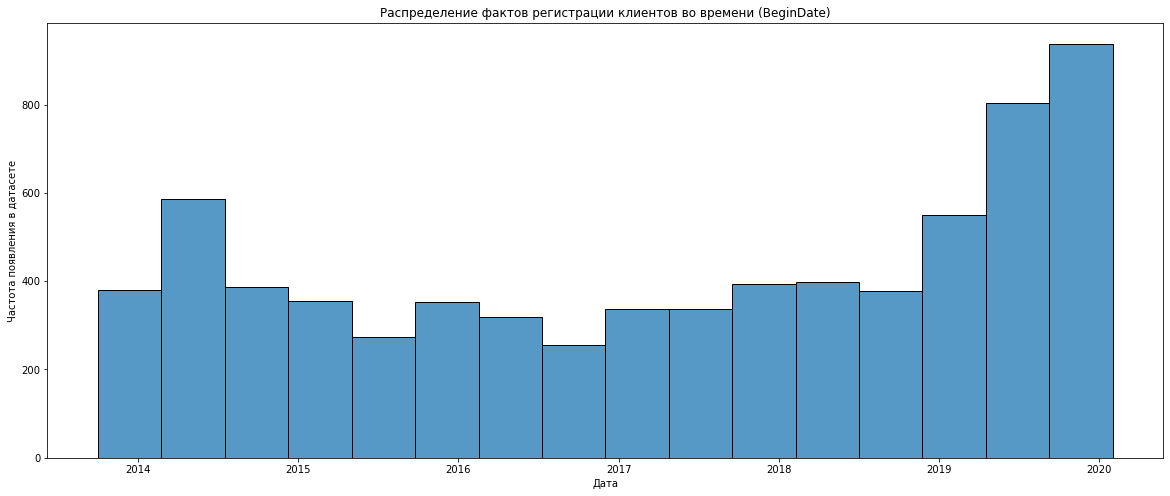

In [117]:
plt.figure(figsize = (20,8))
sns.histplot(df_telecom['BeginDate'])
plt.title('Распределение фактов регистрации клиентов во времени (BeginDate)')
plt.xlabel('Дата')
plt.ylabel('Частота появления в датасете');

Наблюдается пик в начале 2014 года, что связано с началом работы компании. С начала 2015 по конец 2018 года - величина вновь привлеченных клиентов стабильна. Далее с начала 2019 по начало 2020 года снова наблюдаем бурный рост количества новых клиентов.

Посмотрим распределение оттока клиентов во времени:

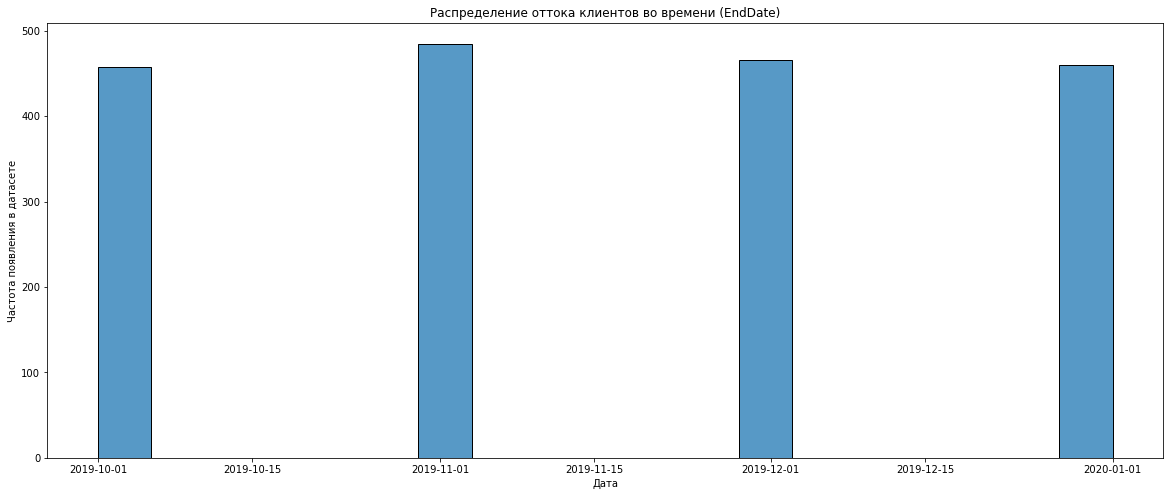

In [118]:
plt.figure(figsize = (20,8))
sns.histplot(df_telecom.query('EndDate != "2020-02-01"')['EndDate'])
plt.title('Распределение оттока клиентов во времени (EndDate)')
plt.xlabel('Дата')
plt.ylabel('Частота появления в датасете');

Посмотрим уникальные значения поля:

In [119]:
df_telecom.query('EndDate != "2020-02-01"')['EndDate'].value_counts()

2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: EndDate, dtype: int64

Только в эти четыре дня происходил отток клиентов, причем распределение практически равномерное

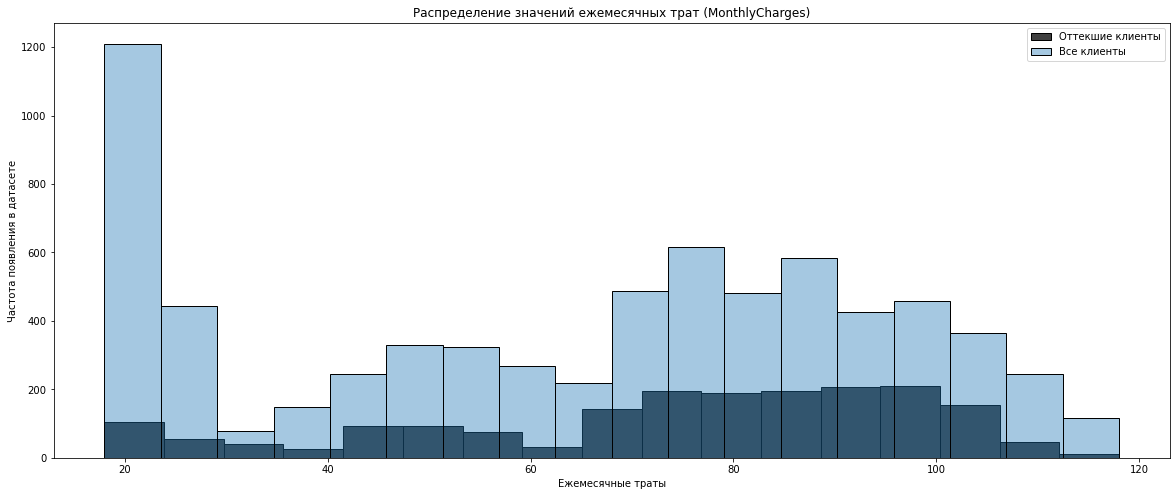

In [120]:
plt.figure(figsize = (20,8))

ax = sns.histplot(df_telecom.loc[df_telecom['escape_client'] == 1,'MonthlyCharges'], 
                  color='black', 
                  label='Оттекшие клиенты')
sns.histplot(df_telecom['MonthlyCharges'],
             ax=ax, 
             alpha=0.4, 
             label='Все клиенты')
ax.legend()
plt.title('Распределение значений ежемесячных трат (MonthlyCharges)')
plt.xlabel('Ежемесячные траты')
plt.ylabel('Частота появления в датасете');

Посмотрим сколько времени ушедшие клиенты пользовались услугами компании:

In [121]:
df_telecom['TotalTime'] = (df_telecom['EndDate'] - df_telecom['BeginDate']).dt.days

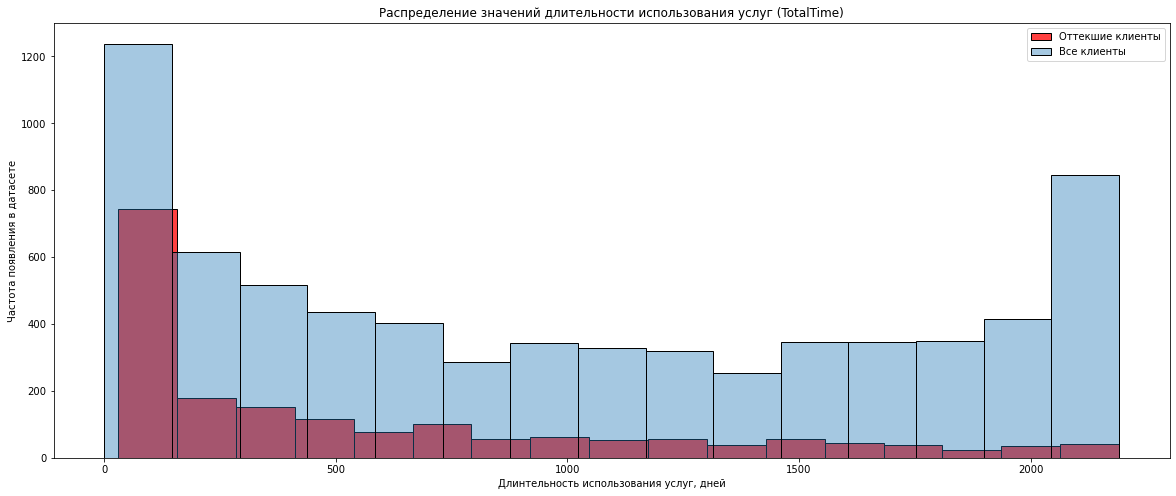

In [122]:
plt.figure(figsize = (20,8))

ax = sns.histplot(df_telecom.query('escape_client == 1')['TotalTime'],
                  color='r', 
                  label='Оттекшие клиенты')
sns.histplot(df_telecom['TotalTime'],
             ax=ax, 
             alpha=0.4, 
             label='Все клиенты')
ax.legend()
plt.title('Распределение значений длительности использования услуг (TotalTime)')
plt.xlabel('Длинтельность использования услуг, дней')
plt.ylabel('Частота появления в датасете');

In [123]:
df_telecom.query('escape_client == 1')['TotalTime'].describe() 

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: TotalTime, dtype: float64

In [124]:
df_telecom['TotalTime'].describe()

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: TotalTime, dtype: float64

Средняя длительность пользования услугами у оттекших клиентов практически в два раза меньше, чем у тех, которые остались

# Подготовка данных для модели

In [125]:
SEED = 70722

Удалим признаки с датой:

In [126]:
df_telecom = df_telecom.drop(['BeginDate', 'EndDate'], axis=1)

In [127]:
df_telecom.shape

(7043, 20)

Закодируем два оставшихся признака прямым кодированием. В данном случае это самый рациональный метод кодирования, так как пространство признаков не большое, и число признаков увеличится всего на 4.

In [129]:
df = pd.get_dummies(df_telecom, drop_first=True)
df.shape


(7043, 24)

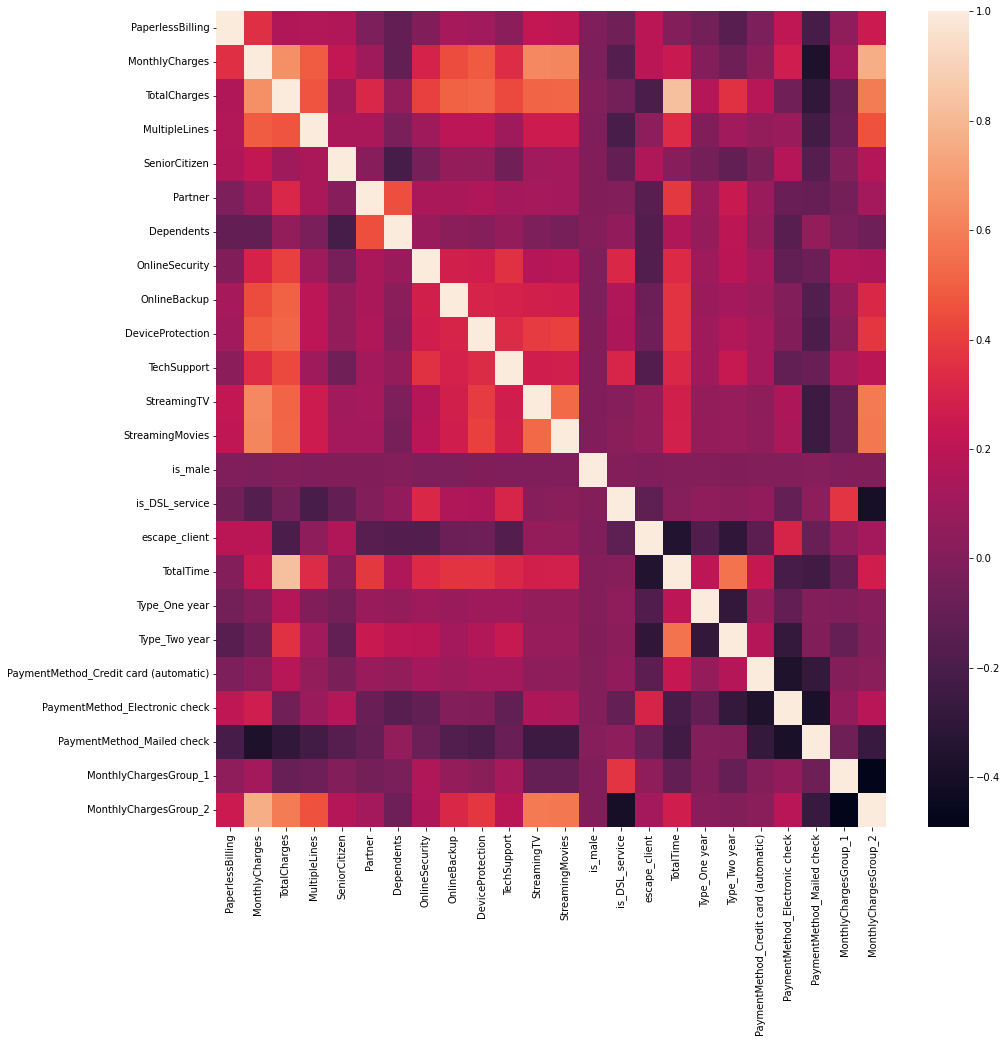

In [130]:
corrMatrix = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corrMatrix, annot=False);

Сгенерированный признак длительности использования услуг компании очень сильно коррелирует с суммарными тратами (корреляции по бинарным признакам не оцениваем). Действительно, признаки дублируют друг друга по своей сути. Так как отношение ежемесячных трат и суммарных трат по сути и будет являтся длительностью использования услуг компании. Сделаем два варианта данных для моделей с ними и без них.

Остальные признаки имеют умеренную и слабую корреляцию. Посмотрим на коэффициент инфляции диспресии

In [131]:
pd.Series([variance_inflation_factor(df.values, i)for i in range(df.shape[1])],index=df.columns)


PaperlessBilling                          2.939183
MonthlyCharges                           41.063204
TotalCharges                             17.341021
MultipleLines                             2.670912
SeniorCitizen                             1.371209
Partner                                   2.819411
Dependents                                1.959808
OnlineSecurity                            2.180569
OnlineBackup                              2.342027
DeviceProtection                          2.421458
TechSupport                               2.261035
StreamingTV                               3.223822
StreamingMovies                           3.262297
is_male                                   1.971995
is_DSL_service                            3.171590
escape_client                             1.884632
TotalTime                                15.598557
Type_One year                             1.974671
Type_Two year                             3.335466
PaymentMethod_Credit card (auto

Признаки соответствующие ежемесячным тратам, длительности использования услуг, и месячных трат по группам имееют очень большой коэффициент инфляции дисперсии. Можно попробовать построить модель с ними, и без них.

Запишем целевой признак:

In [132]:
target = df['escape_client']

И остальные признаки:

In [133]:
features = df.drop('escape_client', axis=1)

Произведем деление на обучающую и отложенную выборку (возьмем соотношение 4:1):

In [134]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            train_size=.8, 
                                                                            random_state=SEED,
                                                                            stratify=target)

In [135]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((5634, 23), (5634,), (1409, 23), (1409,))

In [136]:
features_train_vif = features_train.drop(['MonthlyCharges', 'TotalTime'] , axis=1)
features_test_vif = features_test.drop(['MonthlyCharges', 'TotalTime'], axis=1)

In [137]:
pd.Series([variance_inflation_factor(features_train_vif.values, i)for i in range(features_train_vif.shape[1])],
          index=features_train_vif.columns)

PaperlessBilling                         2.664609
TotalCharges                             7.803995
MultipleLines                            2.613550
SeniorCitizen                            1.353149
Partner                                  2.739644
Dependents                               1.925772
OnlineSecurity                           2.155069
OnlineBackup                             2.284410
DeviceProtection                         2.414180
TechSupport                              2.150313
StreamingTV                              3.142210
StreamingMovies                          3.180272
is_male                                  1.861288
is_DSL_service                           3.003510
Type_One year                            1.652464
Type_Two year                            2.358273
PaymentMethod_Credit card (automatic)    1.651359
PaymentMethod_Electronic check           2.235709
PaymentMethod_Mailed check               1.516757
MonthlyChargesGroup_1                    2.844975


Все коэффициенты в пределах допустимых значений.

In [138]:
features_train_vif.shape, target_train.shape, features_test_vif.shape, target_test.shape


((5634, 21), (5634,), (1409, 21), (1409,))

In [139]:
target_train.mean(), target_test.mean()

(0.2653532126375577, 0.2654364797728886)

Для борьбы с дисбалансом классов воспользуемся апсемплингом и подготовим третий вариант набора данных:

In [140]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=SEED)
    
    return features_upsampled, target_upsampled

In [141]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)
target_upsampled.mean()

0.5200602968460112

# Разработка и отбор лучшей модели

In [142]:
# Функция обучения моделей с параметрами по умолчанию.
# Аргументы: класс модели, обучающая выборка и (необязательно) режим использования сбалансированной развесовки классов.
# Возвращает метрики на 5-х кратной кросс-валидации в формате Series.
def train (model, features, target, SEED, notation, balanced_weights=False):
    model_instance = None
    class_weights = None
    
    # CatBoost не имеет режима class_weight='balanced', для него веса зададим вручную:
    if balanced_weights == True:
        if model == CatBoostClassifier:
            class_weights = [1 - np.mean(target), np.mean(target)]
        else:
            class_weights = 'balanced'
    
    if model == LogisticRegression:
        model_instance = model(random_state=SEED, solver='lbfgs', max_iter=1000, class_weight=class_weights)
    elif model == RandomForestClassifier:
        model_instance = model(random_state=SEED, n_estimators=100, class_weight=class_weights)
    elif model == CatBoostClassifier:
        model_instance = model(random_state=SEED, verbose=0, class_weights=class_weights)
    else:
        model_instance = model(random_state=SEED, class_weight=class_weights)


    # Обучим модель:
    model_instance.fit(features, target)
        
    # Вычислим интересующие нас метрики:
    f1 = np.mean(cross_val_score(model_instance, features, target, cv=5, scoring=make_scorer(f1_score)))
    roc_auc = np.mean(cross_val_score(model_instance, features, target, cv=5, scoring=make_scorer(roc_auc_score)))
    
    stat = pd.Series([type(model_instance).__name__ + notation, f1, roc_auc], index=['Model', 'F1', 'ROC_AUC'])
    return stat, model_instance

In [143]:
model_list = [LogisticRegression, RandomForestClassifier, CatBoostClassifier]

In [144]:
stats = pd.DataFrame({'Model':[], 'F1':[], 'ROC_AUC':[]})

Обучим модели на всех признаках (raw):

In [145]:
model_instances = []
for model in tqdm(model_list):
    stat_row, model_instance = train (model, features_train, target_train, SEED, '_raw')
    
    new_index = len(stats.index)
    stats.loc[new_index] = stat_row

    model_instances.append(model_instance)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:50<00:00, 36.94s/it]


In [146]:
stats

,Model,F1,ROC_AUC
0,LogisticRegression_raw,0.585972,0.715222
1,RandomForestClassifier_raw,0.598431,0.720946
2,CatBoostClassifier_raw,0.680554,0.770152


Лучшей моделью является CatBoostClassifier, как по F1-мере, так и по roc_auc (0.68 и 0.77 на обучающей выборке с 5-х кратной кросс валидацией соответственно). Запишем ее для тестирования в следующем разделе:

In [147]:
best_model_raw = model_instances[2]

Проделаем то же самое, но с балансировкой классов:



In [148]:
model_instances = []
for model in tqdm(model_list):
    stat_row, model_instance = train (model, features_train, target_train, SEED, '_raw_balanced', balanced_weights=True)
    
    new_index = len(stats.index)
    stats.loc[new_index] = stat_row

    model_instances.append(model_instance)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:42<00:00, 34.17s/it]


In [149]:
stats

,Model,F1,ROC_AUC
0,LogisticRegression_raw,0.585972,0.715222
1,RandomForestClassifier_raw,0.598431,0.720946
2,CatBoostClassifier_raw,0.680554,0.770152
3,LogisticRegression_raw_balanced,0.621495,0.759357
4,RandomForestClassifier_raw_balanced,0.583868,0.712195
5,CatBoostClassifier_raw_balanced,0.565434,0.697768


Показатели регрессионной модели увеличились, но незначительно.У случайного леса показатели не изменились, а у кетбуста показатели снизились.

Обучим модели на признаках скорректированных с помощью коэффициента инфляции дисперссии (без MonthlyCharges и TotalTime):

In [150]:
model_instances = []
for model in tqdm(model_list):
    stat_row, model_instance = train (model, features_train_vif, target_train, SEED, '_vif')
    
    new_index = len(stats.index)
    stats.loc[new_index] = stat_row

    model_instances.append(model_instance)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:35<00:00, 31.74s/it]


In [151]:
stats

,Model,F1,ROC_AUC
0,LogisticRegression_raw,0.585972,0.715222
1,RandomForestClassifier_raw,0.598431,0.720946
2,CatBoostClassifier_raw,0.680554,0.770152
3,LogisticRegression_raw_balanced,0.621495,0.759357
4,RandomForestClassifier_raw_balanced,0.583868,0.712195
5,CatBoostClassifier_raw_balanced,0.565434,0.697768
6,LogisticRegression_vif,0.540634,0.686767
7,RandomForestClassifier_vif,0.544469,0.689153
8,CatBoostClassifier_vif,0.581819,0.711971


Показатели F1-меры и roc_auc снизились. Балансировку классов делать не будем.

Обучим модели на признаках с апсемплингом:

In [152]:
model_instances = []
for model in tqdm(model_list):
    stat_row, model_instance = train (model, features_upsampled, target_upsampled, SEED, '_upsampling')
    
    new_index = len(stats.index)
    stats.loc[new_index] = stat_row

    model_instances.append(model_instance)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:53<00:00, 37.79s/it]


In [153]:
stats

,Model,F1,ROC_AUC
0,LogisticRegression_raw,0.585972,0.715222
1,RandomForestClassifier_raw,0.598431,0.720946
2,CatBoostClassifier_raw,0.680554,0.770152
3,LogisticRegression_raw_balanced,0.621495,0.759357
4,RandomForestClassifier_raw_balanced,0.583868,0.712195
5,CatBoostClassifier_raw_balanced,0.565434,0.697768
6,LogisticRegression_vif,0.540634,0.686767
7,RandomForestClassifier_vif,0.544469,0.689153
8,CatBoostClassifier_vif,0.581819,0.711971
9,LogisticRegression_upsampling,0.785018,0.764646


Качество моделей с апсемплингом существенно вырасло. Лучшей моделью является RandomForestClassifier. Модель случайного леса с апсемплингом увеличила F1-меру с 0.59 до 0.92, а roc_auc c 0.72 до 0.91 (показатели CatBoostClassifier со всеми признаками). Запишем лучшую модель и сравним ее на тестировании с моделью кетбуст на полных данных:

In [154]:
best_model_upsampling = model_instances[1]

# Тестирование

In [162]:
def testing_model(features_test, target_test, model):
    predictions_test = model.predict(features_test)
    probabilities_test = model.predict_proba(features_test)[:,1]
    fpr, tpr, threshold = roc_curve(target_test, probabilities_test)
    
    plt.figure(figsize = (20,8))

    f1 = f1_score(target_test, predictions_test)
    roc_auc = roc_auc_score(target_test, probabilities_test)
    
    print('Класс модели: ', type(model).__name__)
    print('F1-мера: ', f1)
    print('roc-auc: ', roc_auc)
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_test, pos_label=1)
    plt.plot(fpr, tpr, label=type(model).__name__)
    plt.xlabel('Вероятность ошибки 1-рода')
    plt.ylabel('Recall')
    plt.title('ROC-кривая модели класса ' + type(model).__name__)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend();
    
    cmatrix = confusion_matrix(target_test, predictions_test)
    plt.figure(figsize=(20, 8))
    sns.heatmap(cmatrix, 
                annot=True,  
                cmap='Blues', 
                fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
    plt.show();

Протестируем лучшую модель на полных данных (raw):

Класс модели:  CatBoostClassifier
F1-мера:  0.7134328358208956
roc-auc:  0.9037471905758351


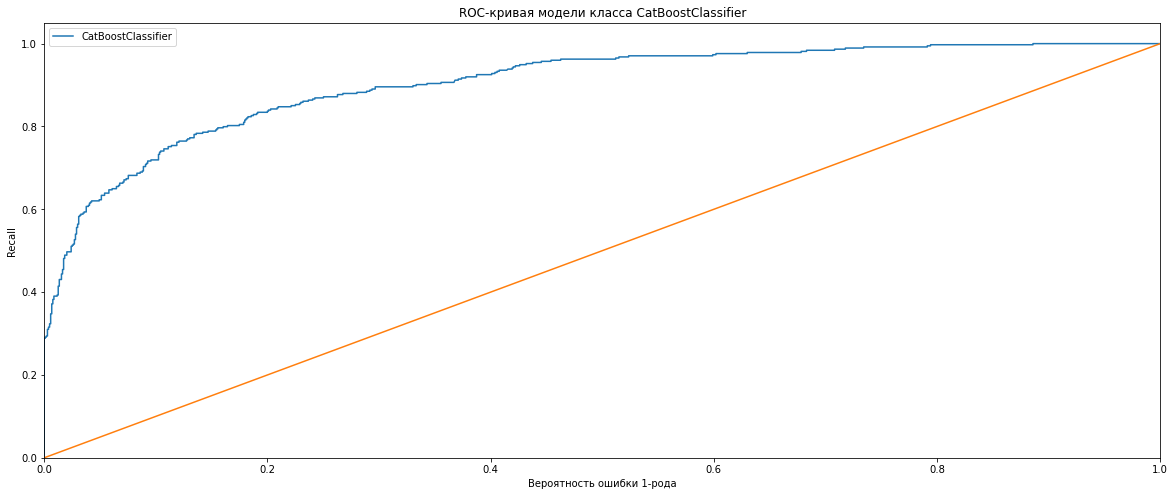

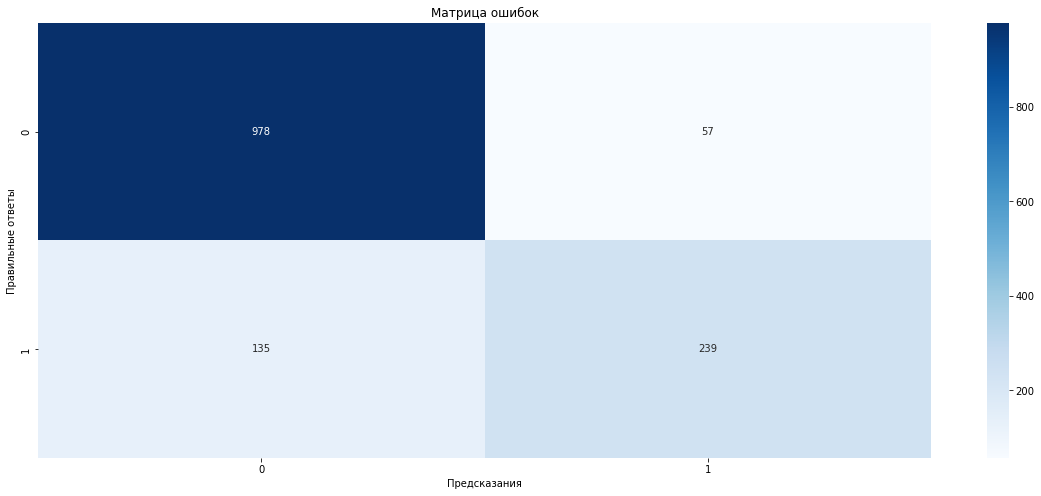

In [163]:
testing_model(features_test, target_test, best_model_raw)

Лучшая модель на данных с апсемплингом (случайный лес):

Класс модели:  RandomForestClassifier
F1-мера:  0.6111833550065019
roc-auc:  0.8324369009791006


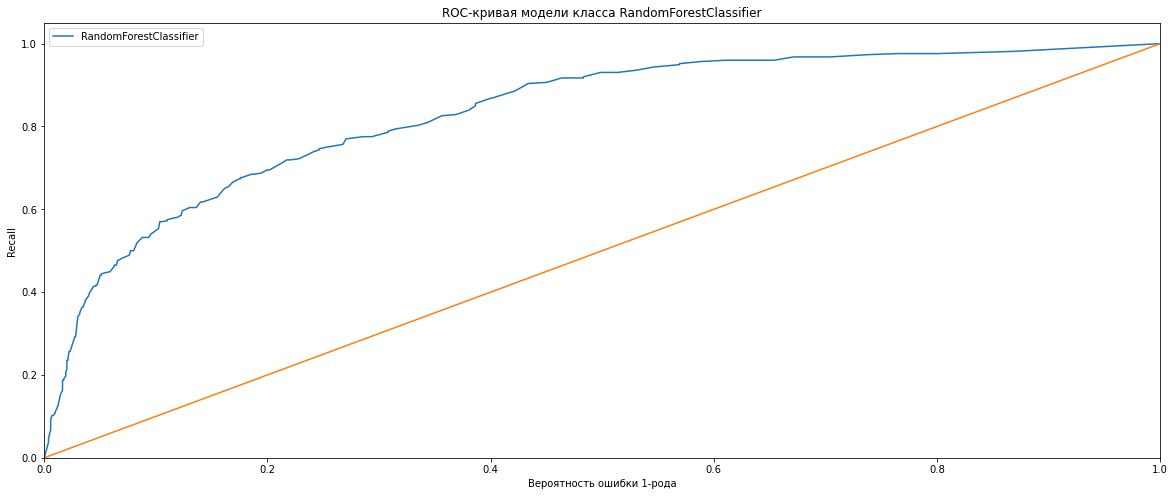

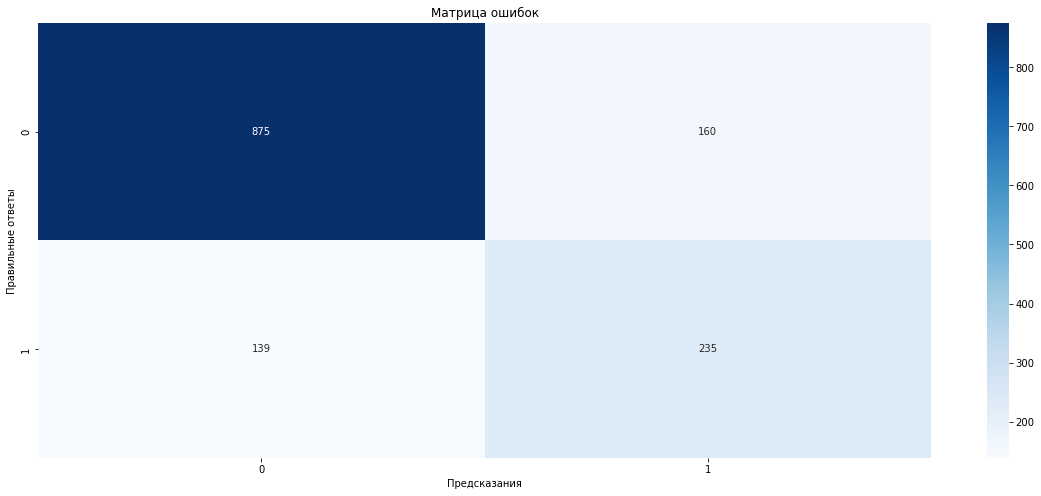

In [164]:
testing_model(features_test, target_test, best_model_upsampling)

Лучшей моделью оказалась модель класса CatBoostClassifier на полных данных. 
Показатели:
F1-мера 0.71;
roc-auc 0.90.

In [165]:
best_model = best_model_raw

# Анализ важности признаков модели


In [167]:
train_dataset = Pool(features_train, target_train)
feature_importance = best_model.get_feature_importance(train_dataset, prettified = True)

In [168]:
feature_importance

,Feature Id,Importances
0,TotalTime,49.158203
1,MonthlyCharges,11.013623
2,TotalCharges,6.982575
3,Type_Two year,6.458374
4,Type_One year,2.990345
5,PaymentMethod_Electronic check,2.597734
6,is_DSL_service,2.537828
7,PaperlessBilling,2.091208
8,TechSupport,1.891189
9,is_male,1.374476


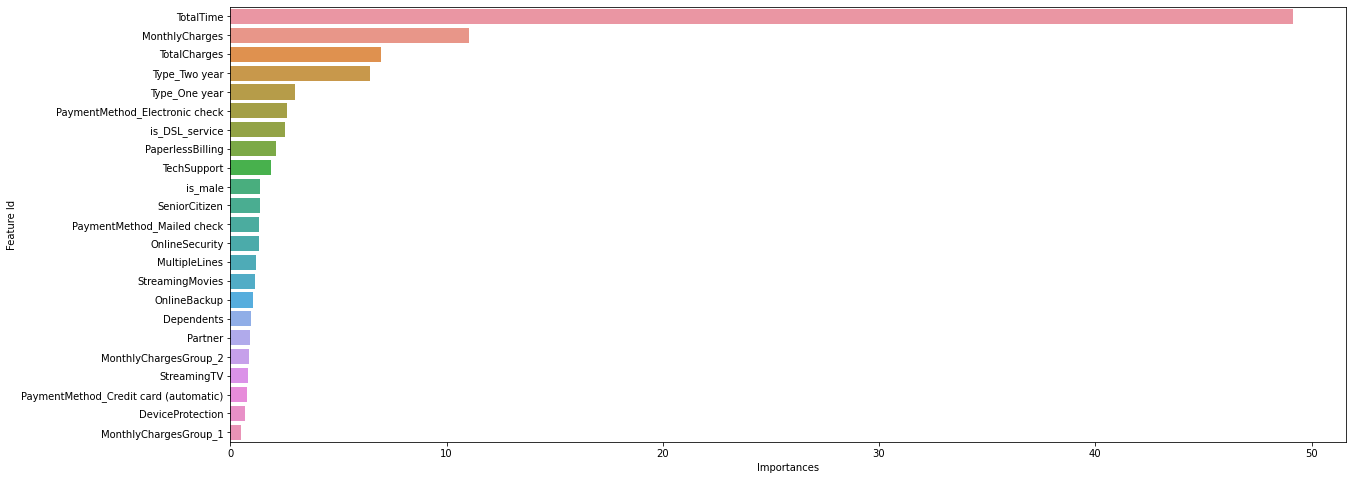

In [170]:
plt.figure(figsize = (20,8))
sns.barplot(y=feature_importance['Feature Id'], x=feature_importance['Importances']);

Достаточно логично, что на лояльность клиентов виляет время использования услуг. Как правило, чем дольше ты пользуешься услугами компании, тем меньше вероятность что ты от туда уйдешь. Второй и третий признак - месячные траты, тоже достаточно логично, учитывая исследовательский анализ данных проведенных ранее. Затем идут признаки, отвечающие за срок договора, гендер и т.д.

В первую очередь на лояльность клиентов влияет время использования услуг. Чем дольше они пользуются услугами компании, тем меньше вероятность что они уйдут.
Второй и третий признак это месячные траты.